Importing Libraries


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
import string
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
sns.set_palette('pastel')
sns.set_style('darkgrid')

Reading data

In [4]:
train_df=pd.read_csv("/content/train.csv")
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [5]:
test_df=pd.read_csv("/content/test.csv")
test_df.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [6]:
print(f'Shape of training data:{train_df.shape}')

print(f'Shape of test data:{test_df.shape}')

Shape of training data:(27481, 4)
Shape of test data:(3534, 3)


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [9]:
#Removing the null column
train_df.dropna(inplace=True)

In [10]:
train_df.shape

(27480, 4)

In [11]:
#Removing the null column
test_df.dropna(inplace=True)

In [12]:
test_df.shape

(3534, 3)

In [13]:
train_df.isna().any()

,0
textID,False
text,False
selected_text,False
sentiment,False


In [14]:
test_df.isna().any()

,0
textID,False
text,False
sentiment,False


In [15]:
train_df['sentiment'].value_counts()

,count
sentiment,
neutral,11117
positive,8582
negative,7781


In [16]:
test_df['sentiment'].value_counts()

,count
sentiment,
neutral,1430
positive,1103
negative,1001


<Axes: xlabel='sentiment', ylabel='count'>

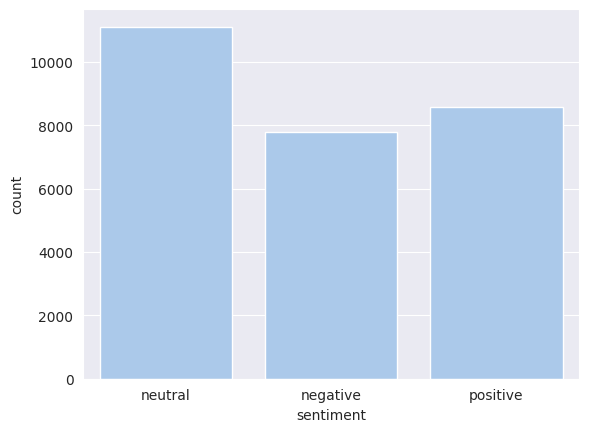

In [17]:
sns.countplot(train_df,x='sentiment')

<Axes: xlabel='sentiment', ylabel='count'>

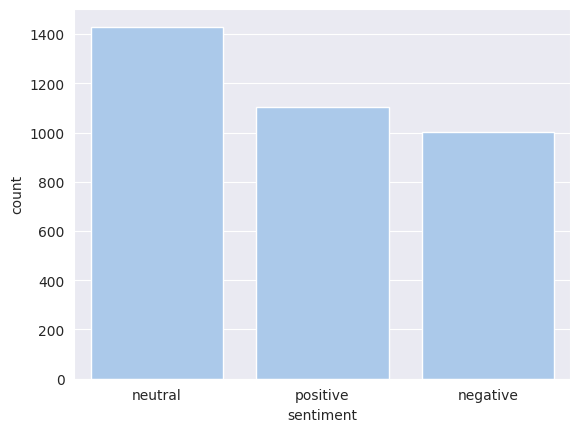

In [18]:
sns.countplot(test_df,x='sentiment')

Preprocessing Input

In [19]:
train_df['text'].head(5)

,text
0,"I`d have responded, if I were going"
1,Sooo SAD I will miss you here in San Diego!!!
2,my boss is bullying me...
3,what interview! leave me alone
4,"Sons of ****, why couldn`t they put them on t..."


In [20]:
#Analyzing texts

for i in np.arange(1,20):

  print(train_df['text'][i])

 Sooo SAD I will miss you here in San Diego!!!
my boss is bullying me...
 what interview! leave me alone
 Sons of ****, why couldn`t they put them on the releases we already bought
http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth
2am feedings for the baby are fun when he is all smiles and coos
Soooo high
 Both of you
 Journey!? Wow... u just became cooler.  hehe... (is that possible!?)
 as much as i love to be hopeful, i reckon the chances are minimal =P i`m never gonna get my cake and stuff
I really really like the song Love Story by Taylor Swift
My Sharpie is running DANGERously low on ink
i want to go to music tonight but i lost my voice.
test test from the LG enV2
Uh oh, I am sunburned
 S`ok, trying to plot alternatives as we speak *sigh*
i`ve been sick for the past few days  and thus, my hair looks wierd.  if i didnt have a hat on it would look... http://tinyurl.com/mnf4kw
is back home now      gonna miss every one
Hes just not that into

In [21]:
import string

import re

Tweets often include repeated characters, hashtags, handles, URLs, emails, contractions, and emojis. We will normalize repeated characters, remove handles, strip # from hashtags, and eliminate URLs and emails using regex. Contractions will be expanded to full forms, and emojis will be converted to text using the emoji package.

In [22]:
pre_web =  r"(([\w]+:)?//)?(([\d\w]|%[a-fA-F\d]{2,2})+(:([\d\w]|%[a-fA-f\d]{2,2})+)?@)?([\d\w][-\d\w]{0,253}[\d\w]\.)+[\w]{2,4}(:[\d]+)?(/([-+_~.\d\w]|%[a-fA-f\d]{2,2})*)*(\?(&?([-+_~.\d\w]|%[a-fA-f\d]{2,2})=?)*)?(#([-+_~.\d\w]|%[a-fA-f\d]{2,2})*)?"

In [23]:
pre_email=r"(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*)@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])"

In [24]:
pre_hash=r'#(\w+)'

In [25]:
pre_handle=r'@\w+'

In [26]:
!pip install emoji

In [27]:
import emoji

In [28]:
!pip install contractions

In [29]:
import contractions

In [30]:
contractions.safety_keys

{"he'll",
 "he's",
 "i'd",
 "i'll",
 "it's",
 "o'",
 "we'd",
 "we'll",
 "we're",
 "who're"}

In [31]:
pre_repeat=r'([A-Za-z])\1{2,}'

In [32]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [33]:
pre_num=r'[0-9]'

In [34]:
re.sub(pre_num," ","i've 4 $ %")

"i've   $ %"

In [35]:
#Defing a function to apply all pre-processing steps



def pre_process(tweet):

  t_mod=re.sub(pre_web,'',tweet)        #Removing URLs

  t_mod=re.sub(pre_email,' ',t_mod)     #Removing email

  t_mod=re.sub(pre_hash," \\1",t_mod)   #Removing '#'

  t_mod=re.sub(pre_handle," ",t_mod)    #Removing handles

  t_mod=emoji.demojize(t_mod)               #De-emojifying


  pre_apos=r'`'                         #Replacing ` with ' to be used in contraction

  t_mod=re.sub(pre_apos,"'",t_mod)


  t_mod=contractions.fix(t_mod)              #Removing contractions


  t_mod=re.sub(pre_repeat,r'\1',t_mod)   #Normalising repeated characters


  pre_num=r'[0-9]'

  t_mod=re.sub(pre_num," ",t_mod)       #Removing numbers


  pre_punc="[" + re.escape(string.punctuation) + "]"       #Removing punctuation

  t_mod=re.sub(pre_punc," ",t_mod)


  t_mod=t_mod.lower()                       #lowering characters


  pre_space=r'\s+'                      #Removing extra white space chars

  t_mod=re.sub(pre_space," ",t_mod)


  return t_mod

In [36]:
train_df['cleaned_text']=train_df['text'].apply(pre_process)

In [37]:
train_df

,textID,text,selected_text,sentiment,cleaned_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,i would have responded if i were going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,so sad i will miss you here in san diego
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons of why could not they put them on the re...
...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,wish we could come see you on denver husband ...
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,i have wondered about rake to the client has ...
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,yay good for both of you enjoy the break you ...
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,but it was worth it


In [38]:
test_df['cleaned_text']=test_df['text'].apply(pre_process)

In [39]:
test_df

,textID,text,sentiment,cleaned_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,last session of the day
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,shanghai is also really exciting precisely sk...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,recession hit veronique branquinho she has to ...
3,01082688c6,happy bday!,positive,happy birthday
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,i like it
...,...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ...",negative,its at am i am very tired but i cannot sleep b...
3530,416863ce47,All alone in this old house again. Thanks for...,positive,all alone in this old house again thanks for t...
3531,6332da480c,I know what you mean. My little dog is sinkin...,negative,i know what you mean my little dog is sinking...
3532,df1baec676,_sutra what is your next youtube video gonna b...,positive,sutra what is your next youtube video going t...


In [40]:
from nltk.tokenize import TreebankWordTokenizer

In [41]:
tokenizer=TreebankWordTokenizer()

In [42]:
train_df['tokens']=train_df['cleaned_text'].apply(lambda x:tokenizer.tokenize(x))

In [43]:
train_df

,textID,text,selected_text,sentiment,cleaned_text,tokens
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,i would have responded if i were going,"[i, would, have, responded, if, i, were, going]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,so sad i will miss you here in san diego,"[so, sad, i, will, miss, you, here, in, san, d..."
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me,"[my, boss, is, bullying, me]"
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave me alone,"[what, interview, leave, me, alone]"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons of why could not they put them on the re...,"[sons, of, why, could, not, they, put, them, o..."
...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,wish we could come see you on denver husband ...,"[wish, we, could, come, see, you, on, denver, ..."
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,i have wondered about rake to the client has ...,"[i, have, wondered, about, rake, to, the, clie..."
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,yay good for both of you enjoy the break you ...,"[yay, good, for, both, of, you, enjoy, the, br..."
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,but it was worth it,"[but, it, was, worth, it]"


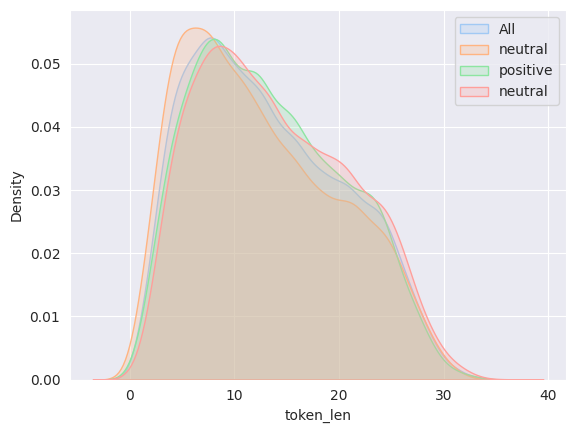

In [44]:
#Checking the length  of tokens

train_df['token_len']=train_df['tokens'].apply(lambda x:len(x))





sns.kdeplot(train_df,x='token_len',legend='All',fill=True,label='All')

sns.kdeplot(train_df[train_df['sentiment']=='neutral'],x='token_len',label='neutral',fill=True)

sns.kdeplot(train_df[train_df['sentiment']=='positive'],x='token_len',label='positive',fill=True)

sns.kdeplot(train_df[train_df['sentiment']=='negative'],x='token_len',label='neutral',fill=True)

plt.legend()

plt.show()


In [45]:
from collections import Counter

In [46]:
ct=Counter()

for token_list in train_df['tokens']:

  ct.update(token_list)

In [47]:
sum(list(ct.values()))

362681

In [48]:
#Most common words in tweets

dict(ct.most_common(50))

{'i': 17681,
 'to': 10979,
 'the': 9124,
 'a': 6819,
 'you': 6641,
 'is': 6639,
 'not': 6101,
 'my': 5549,
 'it': 5424,
 'and': 5170,
 'am': 4115,
 'in': 3818,
 'for': 3658,
 'have': 3297,
 'of': 3284,
 'that': 3170,
 'me': 2877,
 'on': 2875,
 'so': 2870,
 'do': 2446,
 'but': 2406,
 'are': 2309,
 'just': 2277,
 'day': 2166,
 'with': 2098,
 'be': 2023,
 'was': 1980,
 'at': 1901,
 'can': 1876,
 'will': 1860,
 'all': 1685,
 'now': 1595,
 'good': 1579,
 'this': 1572,
 'going': 1569,
 'out': 1523,
 'up': 1508,
 's': 1455,
 'no': 1447,
 'get': 1434,
 'like': 1353,
 'go': 1286,
 'got': 1248,
 'love': 1207,
 'your': 1170,
 'today': 1155,
 'work': 1152,
 'too': 1127,
 'what': 1085,
 'we': 1039}

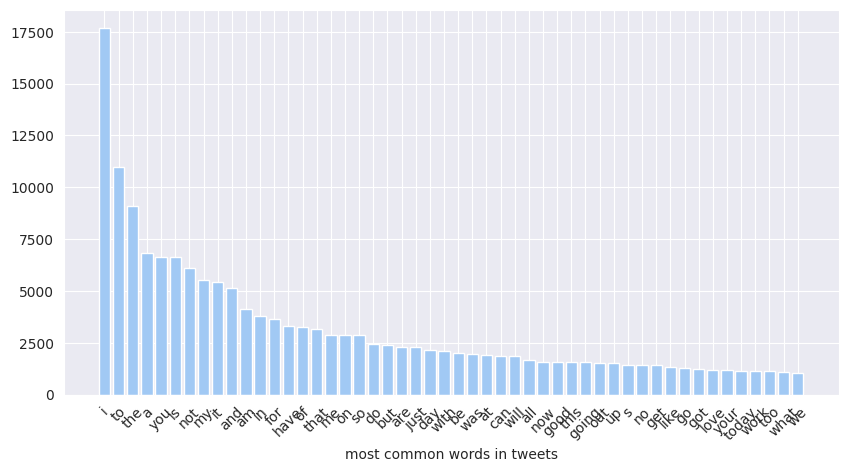

In [49]:
#Distribution of 50 most common tokens

plt.figure(figsize=(10,5))

plt.bar(x=dict(ct.most_common(50)).keys(),height=dict(ct.most_common(50)).values())

plt.xticks(rotation=45)

plt.xlabel('most common words in tweets')

plt.show()

In [50]:
from nltk.corpus import stopwords

In [51]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [52]:
stopword_list=stopwords.words('english')

In [53]:
train_df['tokens_wo_stopwords']=train_df['tokens'].apply(lambda x:[i for i in x if i not in stopword_list])

In [54]:
train_df

,textID,text,selected_text,sentiment,cleaned_text,tokens,token_len,tokens_wo_stopwords
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,i would have responded if i were going,"[i, would, have, responded, if, i, were, going]",8,"[would, responded, going]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,so sad i will miss you here in san diego,"[so, sad, i, will, miss, you, here, in, san, d...",10,"[sad, miss, san, diego]"
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me,"[my, boss, is, bullying, me]",5,"[boss, bullying]"
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave me alone,"[what, interview, leave, me, alone]",5,"[interview, leave, alone]"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons of why could not they put them on the re...,"[sons, of, why, could, not, they, put, them, o...",14,"[sons, could, put, releases, already, bought]"
...,...,...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,wish we could come see you on denver husband ...,"[wish, we, could, come, see, you, on, denver, ...",17,"[wish, could, come, see, denver, husband, lost..."
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,i have wondered about rake to the client has ...,"[i, have, wondered, about, rake, to, the, clie...",25,"[wondered, rake, client, made, clear, net, for..."
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,yay good for both of you enjoy the break you ...,"[yay, good, for, both, of, you, enjoy, the, br...",21,"[yay, good, enjoy, break, probably, need, hect..."
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,but it was worth it,"[but, it, was, worth, it]",5,[worth]


In [55]:
from nltk.stem import WordNetLemmatizer

In [56]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [57]:
lemmatizer = WordNetLemmatizer()

In [58]:
lemmatizer.lemmatize('gives')

'give'

In [59]:
train_df['tokens_lemma']=train_df['tokens_wo_stopwords'].apply(lambda x:[lemmatizer.lemmatize(i) for i in x])

train_df['tokens_lemma']

,tokens_lemma
0,"[would, responded, going]"
1,"[sad, miss, san, diego]"
2,"[bos, bullying]"
3,"[interview, leave, alone]"
4,"[son, could, put, release, already, bought]"
...,...
27476,"[wish, could, come, see, denver, husband, lost..."
27477,"[wondered, rake, client, made, clear, net, for..."
27478,"[yay, good, enjoy, break, probably, need, hect..."
27479,[worth]


In [60]:
#Counters for listing tokens



ct_all=Counter()

ct_neutral=Counter()

ct_positive=Counter()

ct_negative=Counter()



for token_list in train_df['tokens_lemma']:

  ct_all.update(token_list)



for token_list in train_df[train_df['sentiment']=='neutral']['tokens_lemma']:

  ct_neutral.update(token_list)



for token_list in train_df[train_df['sentiment']=='positive']['tokens_lemma']:

  ct_positive.update(token_list)



for token_list in train_df[train_df['sentiment']=='negative']['tokens_lemma']:

  ct_negative.update(token_list)

In [61]:
dict(ct_all.most_common(50)).values()

dict_values([2508, 1580, 1569, 1528, 1380, 1365, 1287, 1248, 1201, 1163, 1099, 1090, 1075, 1045, 1030, 996, 930, 919, 821, 819, 795, 764, 751, 749, 748, 744, 721, 716, 689, 665, 655, 636, 626, 621, 613, 604, 591, 590, 571, 569, 559, 550, 543, 540, 532, 523, 520, 494, 492, 492])

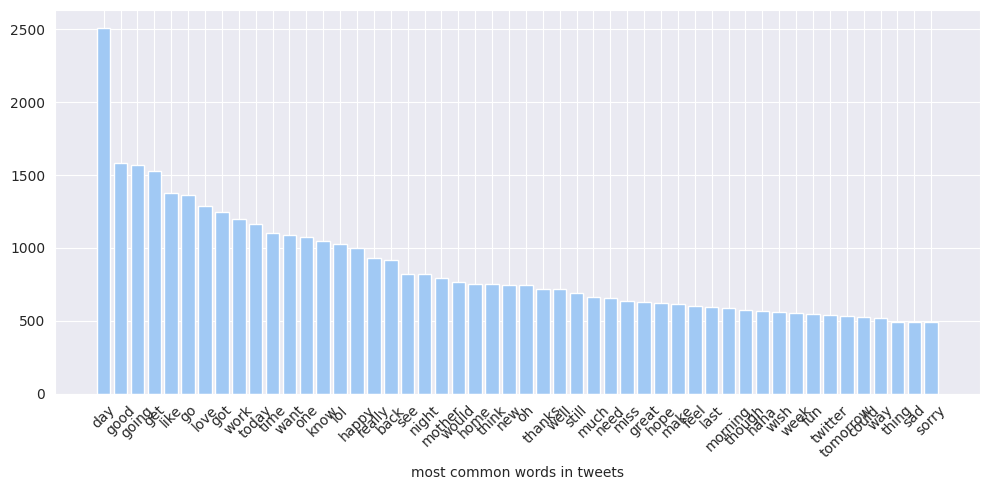

In [62]:
#Distribution of 50 most common tokens

plt.figure(figsize=(10,5))

plt.bar(x=dict(ct_all.most_common(50)).keys(),height=dict(ct_all.most_common(50)).values())

plt.xticks(rotation=45)

plt.xlabel('most common words in tweets')

plt.tight_layout()

plt.show()

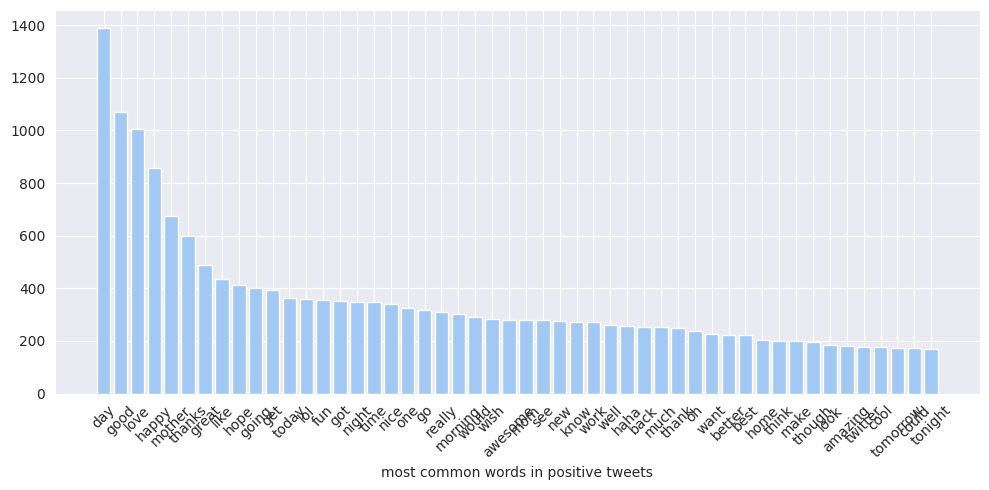

In [63]:
#Distribution of 50 most common positive tokens

plt.figure(figsize=(10,5))

plt.bar(x=dict(ct_positive.most_common(50)).keys(),height=dict(ct_positive.most_common(50)).values())

plt.xticks(rotation=45)

plt.xlabel('most common words in positive tweets')

plt.tight_layout()

plt.show()

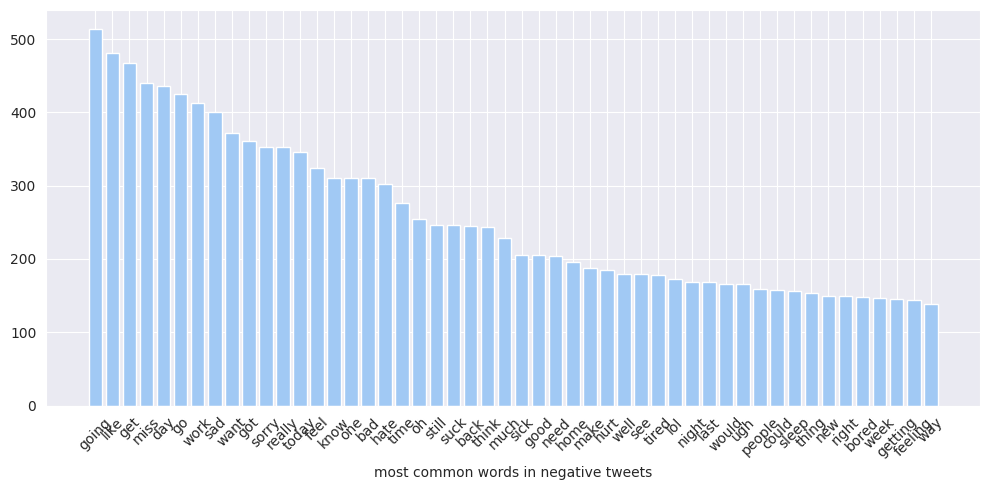

In [64]:
#Distribution of 50 most common negative tokens

plt.figure(figsize=(10,5))

plt.bar(x=dict(ct_negative.most_common(50)).keys(),height=dict(ct_negative.most_common(50)).values())

plt.xticks(rotation=45)

plt.xlabel('most common words in negative tweets')

plt.tight_layout()

plt.show()

In [65]:
!pip install wordcloud

In [66]:
from wordcloud import WordCloud

In [67]:
def generate_wordcloud(list_,label_list):

  plt.figure(figsize=(10,20))

  k=1

  for i in list_:

    plt.subplot(len(list_),1,k)

    word_cloud=WordCloud()

    word_cloud.generate_from_frequencies(i)

    plt.imshow(word_cloud)

    plt.grid(False)

    plt.xticks([])

    plt.yticks([])

    plt.xlabel(label_list[k-1])

    k+=1

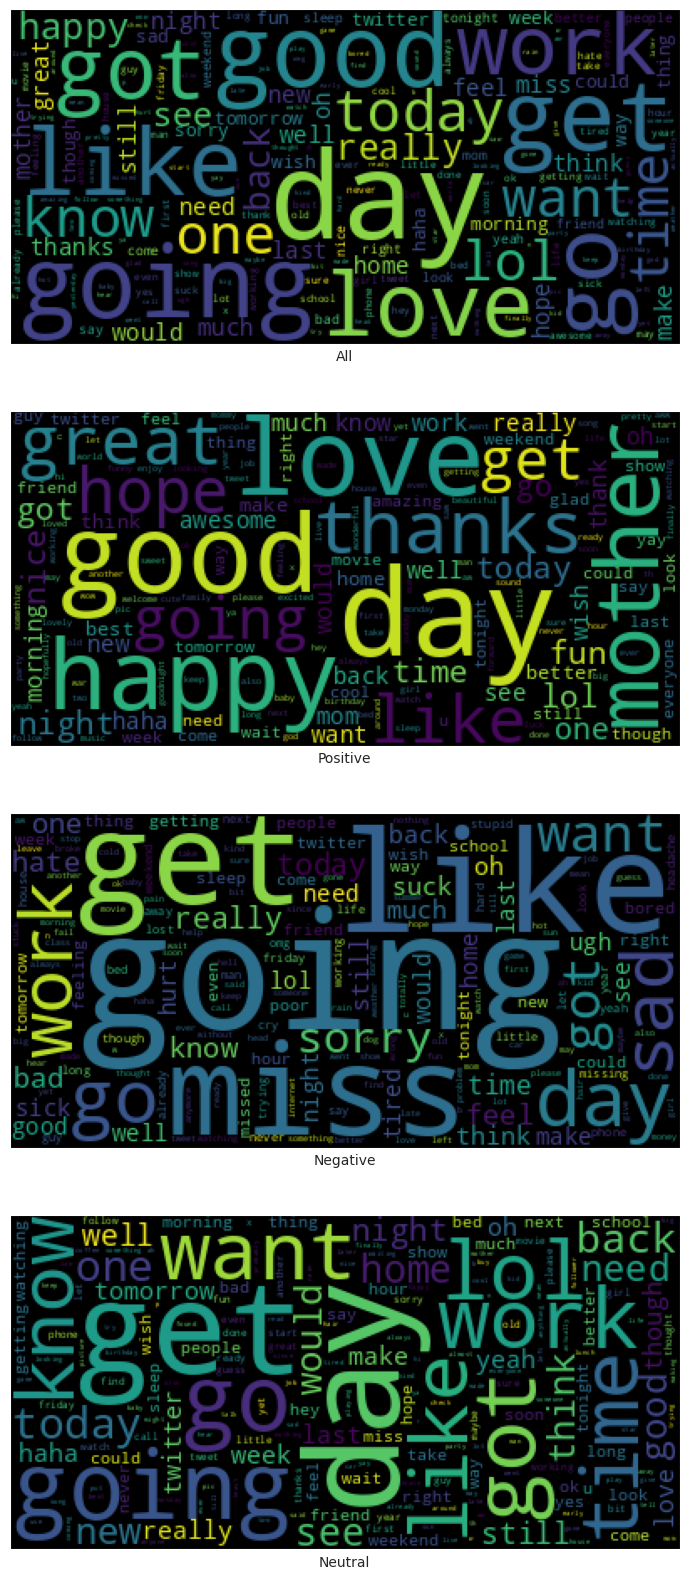

In [68]:
generate_wordcloud([ct_all,ct_positive,ct_negative,ct_neutral],['All','Positive','Negative','Neutral'])

In [69]:
#Getting the final data

train_df_chosen=train_df[['tokens','sentiment']]

train_df_chosen

,tokens,sentiment
0,"[i, would, have, responded, if, i, were, going]",neutral
1,"[so, sad, i, will, miss, you, here, in, san, d...",negative
2,"[my, boss, is, bullying, me]",negative
3,"[what, interview, leave, me, alone]",negative
4,"[sons, of, why, could, not, they, put, them, o...",negative
...,...,...
27476,"[wish, we, could, come, see, you, on, denver, ...",negative
27477,"[i, have, wondered, about, rake, to, the, clie...",negative
27478,"[yay, good, for, both, of, you, enjoy, the, br...",positive
27479,"[but, it, was, worth, it]",positive


In [70]:
#Converting target class to on-hot vector

train_df_final=pd.get_dummies(train_df_chosen,columns=['sentiment'],dtype='int')



train_df_final['sentence']=train_df_final['tokens'].apply(lambda x:" ".join(x))   #Converting tokens back to string to process in Vectorizer

train_df_final

,tokens,sentiment_negative,sentiment_neutral,sentiment_positive,sentence
0,"[i, would, have, responded, if, i, were, going]",0,1,0,i would have responded if i were going
1,"[so, sad, i, will, miss, you, here, in, san, d...",1,0,0,so sad i will miss you here in san diego
2,"[my, boss, is, bullying, me]",1,0,0,my boss is bullying me
3,"[what, interview, leave, me, alone]",1,0,0,what interview leave me alone
4,"[sons, of, why, could, not, they, put, them, o...",1,0,0,sons of why could not they put them on the rel...
...,...,...,...,...,...
27476,"[wish, we, could, come, see, you, on, denver, ...",1,0,0,wish we could come see you on denver husband l...
27477,"[i, have, wondered, about, rake, to, the, clie...",1,0,0,i have wondered about rake to the client has m...
27478,"[yay, good, for, both, of, you, enjoy, the, br...",0,0,1,yay good for both of you enjoy the break you p...
27479,"[but, it, was, worth, it]",0,0,1,but it was worth it


<Axes: xlabel='sentence_length'>

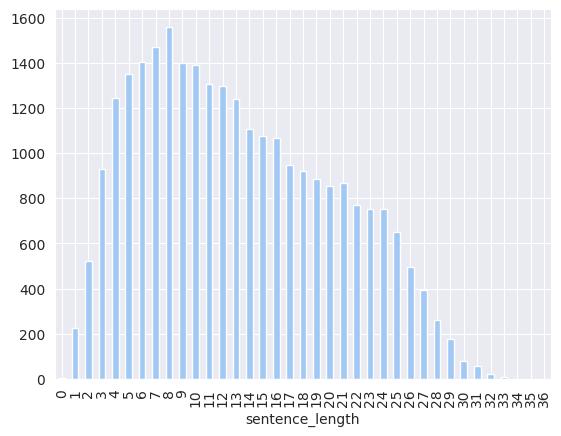

In [71]:
#Checking the length of sentence
train_df_final['sentence_length']=train_df_final['sentence'].apply(lambda x:len(x.split()))
train_df_final['sentence_length'].value_counts().sort_index().plot.bar()

In [72]:
#Getting the test dataset

test_df

,textID,text,sentiment,cleaned_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,last session of the day
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,shanghai is also really exciting precisely sk...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,recession hit veronique branquinho she has to ...
3,01082688c6,happy bday!,positive,happy birthday
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,i like it
...,...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ...",negative,its at am i am very tired but i cannot sleep b...
3530,416863ce47,All alone in this old house again. Thanks for...,positive,all alone in this old house again thanks for t...
3531,6332da480c,I know what you mean. My little dog is sinkin...,negative,i know what you mean my little dog is sinking...
3532,df1baec676,_sutra what is your next youtube video gonna b...,positive,sutra what is your next youtube video going t...


In [73]:
test_df['tokens']=test_df['cleaned_text'].apply(lambda x:tokenizer.tokenize(x))   #Applying tokenizer

In [74]:
test_df_chosen=test_df[['tokens','sentiment']]

test_df_final=pd.get_dummies(test_df_chosen,columns=['sentiment'],dtype='int')



test_df_final['sentence']=test_df_final['tokens'].apply(lambda x:" ".join(x))

test_df_final

,tokens,sentiment_negative,sentiment_neutral,sentiment_positive,sentence
0,"[last, session, of, the, day]",0,1,0,last session of the day
1,"[shanghai, is, also, really, exciting, precise...",0,0,1,shanghai is also really exciting precisely sky...
2,"[recession, hit, veronique, branquinho, she, h...",1,0,0,recession hit veronique branquinho she has to ...
3,"[happy, birthday]",0,0,1,happy birthday
4,"[i, like, it]",0,0,1,i like it
...,...,...,...,...,...
3529,"[its, at, am, i, am, very, tired, but, i, can,...",1,0,0,its at am i am very tired but i can not sleep ...
3530,"[all, alone, in, this, old, house, again, than...",0,0,1,all alone in this old house again thanks for t...
3531,"[i, know, what, you, mean, my, little, dog, is...",1,0,0,i know what you mean my little dog is sinking ...
3532,"[sutra, what, is, your, next, youtube, video, ...",0,0,1,sutra what is your next youtube video going to...


<Axes: xlabel='sentence_length'>

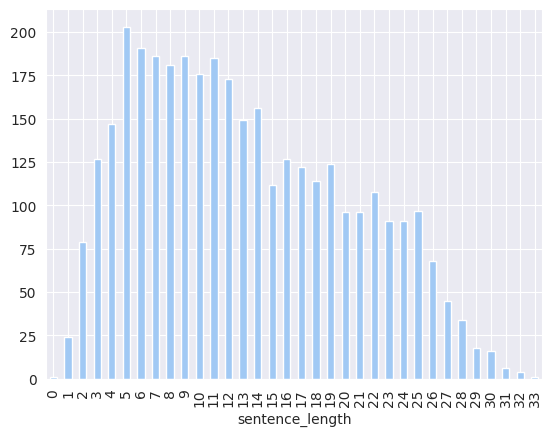

In [75]:
#Checking the length of sentence
test_df_final['sentence_length']=test_df_final['sentence'].apply(lambda x:len(x.split()))
test_df_final['sentence_length'].value_counts().sort_index().plot.bar()

In [76]:
#Dropping the occurences of null length
test_df_final=test_df_final.drop(test_df_final[test_df_final['sentence_length']==0].index,axis=0)

In [77]:
train_df_features=train_df_final['sentence']

train_df_targets=train_df_final[['sentiment_negative','sentiment_neutral','sentiment_positive']]



test_df_features=test_df_final['sentence']

test_df_targets=test_df_final[['sentiment_negative','sentiment_neutral','sentiment_positive']]

In [78]:
#Splitting into train and validation sets

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val=train_test_split(train_df_features,train_df_targets,random_state=42,shuffle=True,test_size=0.2)

In [79]:
X_test=test_df_features

y_test=test_df_targets

In [80]:
#Checking shape of our dataset

print(f"Shape of X train:{X_train.shape}")

print(f"Shape of X val:{X_val.shape}")

print(f"Shape of X test:{X_test.shape}")

print(f"Shape of Y train:{y_train.shape}")

print(f"Shape of Y val:{y_val.shape}")

print(f"Shape of Y test:{y_test.shape}")

Shape of X train:(21984,)
Shape of X val:(5496,)
Shape of X test:(3533,)
Shape of Y train:(21984, 3)
Shape of Y val:(5496, 3)
Shape of Y test:(3533, 3)


Encoding Labels

In [81]:
sentiments = {'neutral':1, 'negative':0, 'positive':2}
train_df['sentiment'] = train_df.sentiment.map(sentiments)
test_df['sentiment'] = test_df.sentiment.map(sentiments)

In [82]:
print(train_df['sentiment'].value_counts(), test_df['sentiment'].value_counts(), sep='\n')

sentiment
1    11117
2     8582
0     7781
Name: count, dtype: int64
sentiment
1    1430
2    1103
0    1001
Name: count, dtype: int64


In [83]:
X_train, X_val, y_train, y_val = train_test_split(train_df['cleaned_text'],
                                                  train_df['sentiment'],
                                                  stratify=train_df['sentiment'],
                                                  random_state=0, test_size=0.2)

In [84]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.70, ngram_range=(1, 3), max_features=10_000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

In [85]:
X_train.shape

(21984,)

In [86]:
len(tfidf.get_feature_names_out())

10000

Training & Evaluating

In [87]:
clf = SVC()
clf.fit(X_train_tfidf, y_train)

SVC()

Validation Accuracy: 0.7014192139737991
Confusion Matrix


<Axes: >

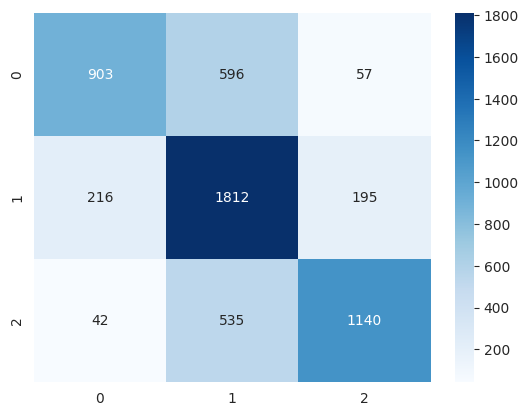

In [88]:
y_pred = clf.predict(X_val_tfidf)
cm= confusion_matrix(y_val, y_pred)
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred)}")
print("Confusion Matrix")
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

Test Accuracy:  0.6966610073571025
Confusion Matrix


<Axes: >

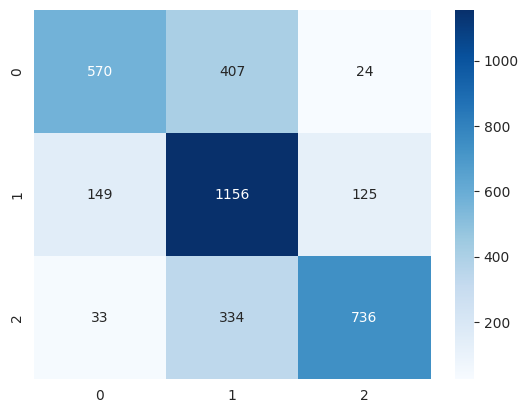

In [89]:
predictions = clf.predict(tfidf.transform(test_df['cleaned_text']))
cm= confusion_matrix(test_df['sentiment'], predictions)
print("Test Accuracy: ", accuracy_score(test_df['sentiment'], predictions))
print('Confusion Matrix')
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

In [90]:
from sklearn.preprocessing import LabelEncoder

In [91]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_df['sentiment'])

In [92]:
y = train_df['sentiment']

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

In [94]:
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

LogisticRegression()

In [95]:
y_pred = model.predict(X_train_tfidf)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.75      0.80      6225
           1       0.75      0.86      0.80      8894
           2       0.88      0.80      0.84      6865

    accuracy                           0.81     21984
   macro avg       0.83      0.80      0.81     21984
weighted avg       0.82      0.81      0.81     21984



In [96]:
from sklearn.ensemble import RandomForestClassifier

In [97]:
X_text = [" ".join(tokens) for tokens in train_df_final['tokens']]

In [98]:
tfidf = TfidfVectorizer(max_features=10000)
X = tfidf.fit_transform(X_text)

In [99]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [100]:
rf = RandomForestClassifier(random_state=42)

In [101]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5],
}


In [102]:
grid = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

In [103]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 20], 'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=2)

In [104]:
y_pred = grid.predict(X_val)
print("Best Parameters:", grid.best_params_)
print("\nClassification Report:\n")
print("Label classes:", label_encoder.classes_)
print(classification_report(y_val, y_pred, target_names=['negative', 'neutral', 'positive']))


Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}

Classification Report:

Label classes: [0 1 2]
              precision    recall  f1-score   support

    negative       0.73      0.54      0.62      1556
     neutral       0.60      0.77      0.68      2223
    positive       0.79      0.69      0.74      1717

    accuracy                           0.68      5496
   macro avg       0.71      0.67      0.68      5496
weighted avg       0.70      0.68      0.68      5496



In [108]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Masking


In [110]:
from keras.layers import TextVectorization

text_vectorization = TextVectorization(
    max_tokens=22520,  # or however many tokens you saw during `Counter()`
    output_mode="int",
    output_sequence_length=35,
    pad_to_max_tokens=True
)

# Adapt the layer on your token list
token_list = list(sorted(ct.keys()))  # assuming you have a Counter object `ct`
text_vectorization.adapt(token_list)

# Now get vocab size
max_tokens = text_vectorization.vocabulary_size()


In [119]:
from keras.layers import TextVectorization
import tensorflow as tf

# Rebuild using text
X_texts = [" ".join(tokens) for tokens in train_df_final['tokens']]
text_vectorization = TextVectorization(max_tokens=22520, output_mode="int", output_sequence_length=35)
text_vectorization.adapt(X_texts)



In [124]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['sentiment'])  # or 'sentiment_label' if already encoded



In [125]:
X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_texts, train_df['label'], test_size=0.2, stratify=train_df['label'], random_state=42
)


In [111]:
# Now get vocab size
max_tokens = text_vectorization.vocabulary_size()

In [112]:
num_classes = len(set(y_train))
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)

In [113]:
model = Sequential([
    Input(shape=(35,)),                         # input layer
    Masking(mask_value=-999),                   # mask padding
    Embedding(input_dim=max_tokens + 1, output_dim=128),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'embedding' (of type Embedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [114]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 35, 128)        │     2,882,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,936,451 (11.20 MB)

 Trainable params: 2,936,451 (11.20 MB)

 Non-trainable params: 0 (0.00 B)

In [129]:
X_train_vector = change_padding_values(text_vectorization(tf.constant(X_train_text)), mask_value=-999)
X_val_vector = change_padding_values(text_vectorization(tf.constant(X_val_text)), mask_value=-999)


In [130]:
history = model.fit(
    X_train_vector, y_train_cat,
    validation_data=(X_val_vector, y_val_cat),
    epochs=5,
    batch_size=32
)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'embedding' (of type Embedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - accuracy: 0.4306 - loss: 1.0580 - val_accuracy: 0.6810 - val_loss: 0.7502
Epoch 2/5
687/687 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 0.7371 - loss: 0.6643 - val_accuracy: 0.7132 - val_loss: 0.6926
Epoch 3/5
687/687 ━━━━━━━━━━━━━━━━━━━━ 43s 58ms/step - accuracy: 0.8199 - loss: 0.4813 - val_accuracy: 0.7063 - val_loss: 0.7045
Epoch 4/5
687/687 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step - accuracy: 0.8809 - loss: 0.3415 - val_accuracy: 0.6929 - val_loss: 0.7858
Epoch 5/5
687/687 ━━━━━━━━━━━━━━━━━━━━ 44s 58ms/step - accuracy: 0.9102 - loss: 0.2650 - val_accuracy: 0.6869 - val_loss: 0.8983


In [131]:
loss, acc = model.evaluate(X_val_vector, y_val_cat)
print(f"Validation Accuracy: {acc:.4f}")


172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6795 - loss: 0.9218
Validation Accuracy: 0.6869


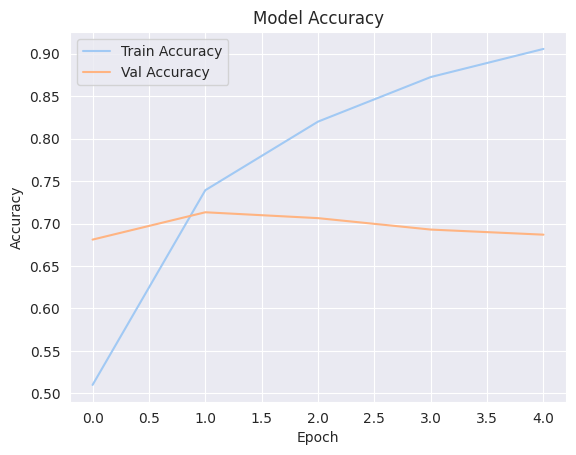

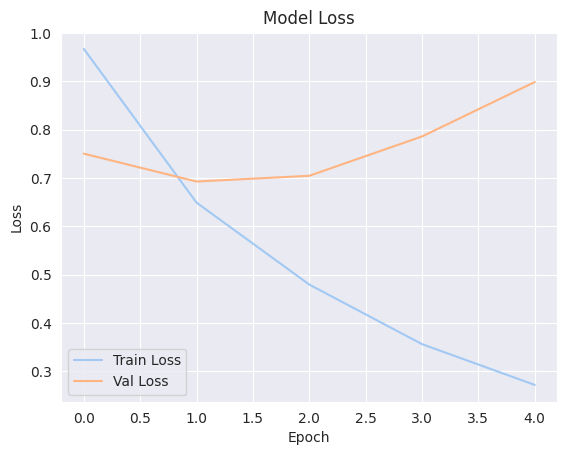

In [132]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
